In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ESSENTIA

## Processamento inicial

In [25]:
import essentia.standard as es

In [26]:
sr = 44100 # resample 96 kHz para 44.1Khz: taxa de amostragem 96 kHz dos audios da pasta '../dados/audios/'
frame_size = 1024 # approx: 23.2 ms
hop_size = 256 # 5.8 ms

In [27]:
def carregaAudioMono(audio_caminho):
    
    audio = es.MonoLoader( # monoloader de padrao usa replayGain -6dB
        filename=audio_caminho,
        sampleRate=sr,
        resampleQuality= 0, #documentação: "0 for best quality, 4 for fast linear approximation"
    )()

    return audio

In [28]:
# Realiza processamento dos arquivos .wav para array numerico e os armazena

from collections import defaultdict

audio_pasta = '../dados/audios/'
audios_processados = defaultdict(lambda: defaultdict(lambda: defaultdict(dict))) # cria um dicionario vazio de 4 níveis para armazenar a estrutura [nota][material][metodo][rep]

for audio in os.listdir(audio_pasta):

    audio_nome = os.path.splitext(audio)[0]

    nomes_partes = audio_nome.split('_')
    gaita = nomes_partes[0].strip()
    material = nomes_partes[1].strip().lower()
    metodo = nomes_partes[2].strip().lower()
    nota = nomes_partes[3].strip()
    repeticao = nomes_partes[4].strip().replace(' ', '')

    local = audio_pasta + audio
    audios_processados[nota][material][metodo][repeticao] = carregaAudioMono(local)

## STFT

In [29]:
def calcSTFT(audio, window='hamming'):

    window = es.Windowing(  # documentação: "results in a Hamming window similar to the default SciPy implementation"
        type=window,
        size = frame_size,
        constantsDecimals=2,
        normalized=False,
        zeroPhase=False
    )
    
    spectrum = es.Spectrum() # documentação: "FFT() would return the complex FFT, here we just want the magnitude spectrum"

    magnitudes = []

    for frame in es.FrameGenerator(audio, frameSize=frame_size, hopSize=hop_size):
        mag = spectrum(window(frame)) 
        magnitudes.append(mag)

    return magnitudes

## Descritores

In [30]:
def calcAttackTime(audio):


    envelope = es.Envelope( #documentação: This algorithm computes the envelope of a signal by applying a non-symmetric lowpass filter on a signal
        sampleRate=sr,
    )(audio)

    log_attack = es.LogAttackTime(
        sampleRate=sr,
        startAttackThreshold=0.2,
        stopAttackThreshold=0.8
    )(envelope)
    # log_attack retorna uma tupla com 3 valores

    attack_time = 10 ** log_attack[0] # converte para tempo em segundos

    return attack_time, log_attack

In [31]:
def notaSustentada(magnitudes):

    frame_times = np.arange(len(magnitudes)) * hop_size / sr

    sel_magnitudes = []

    for i, t in enumerate(frame_times):
        if 2 <= t <= 5:
            sel_magnitudes.append(magnitudes[i])
        else:
            sel_magnitudes.append(np.nan)

    return sel_magnitudes

In [32]:
def calcCentroid_media(magnitudes):
    
    magnitudes = notaSustentada(magnitudes)

    centroid = es.Centroid(range=sr/2) # documentação: "For a spectral centroid [hz], frequency range should be equal to samplerate/2"
    centroids = []

    for mag in magnitudes:
        if mag is np.nan:
            centroids.append(np.nan)
        else:
            centroids.append(centroid(mag)) 

    centroid_media = np.nanmean(centroids)

    return centroids, centroid_media


def calcCentroid_mediana(magnitudes):

    centroid = es.Centroid(range=sr/2)
    centroids = []

    for mag in magnitudes:
        centroids.append(centroid(mag)) 

    centroid_mediana = np.median(centroids)
    return centroids, centroid_mediana


In [33]:
def plotaEspectro(magnitudes, centroids_media, centroids_mediana):

    S = np.array(magnitudes)
    S = S / S.max()
    S_db = 20 * np.log10(S + 1e-8)

    times_media = np.arange(len(centroids_media)) * (hop_size / sr)
    plt.figure(figsize=(5, 5))
    plt.imshow(S_db.T, origin='lower', aspect='auto',
               extent=[0, times_media[-1], 0, sr/2], cmap='magma',
               vmin=-80, vmax=np.max(S_db))

    plt.ylim(0, 20000) 

    plt.colorbar(label='Amplitude (dB)', pad=0.04)
    plt.ylabel('Frequência (Hz)')
    plt.xlabel('Tempo (s)')
    plt.title('Espectrograma')

    plt.plot(times_media, centroids_mediana, color='grey', linewidth=2.5, label='Centroide espectral')
    plt.plot(times_media, centroids_media, color='white', linewidth=2.5, label='Centroide espectral (intervalo adotado)')
    
    #plt.legend(loc='upper right', framealpha=0.8)
    
    plt.show()


In [34]:
def acessaAudiosProc(nota, material, metodo, repeticao):
    y = audios_processados[nota][material][metodo][repeticao]

    return y

# Preview

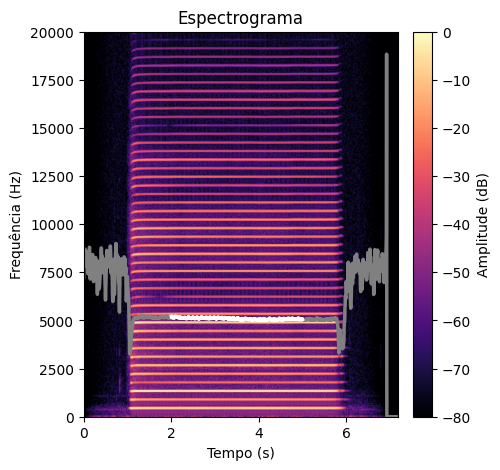

In [35]:
nota = 'A4'
material = 'madeira'
metodo = 'natural'
repeticao = 'rep2'

audio = acessaAudiosProc(nota, material, metodo, repeticao)
stft = calcSTFT(audio)

centroids_media, centroid_media = calcCentroid_media(stft)
centroids_mediana, centroid_mediana = calcCentroid_mediana(stft)
attack_time, _ = calcAttackTime(audio)

plotaEspectro(stft, centroids_media, centroids_mediana)

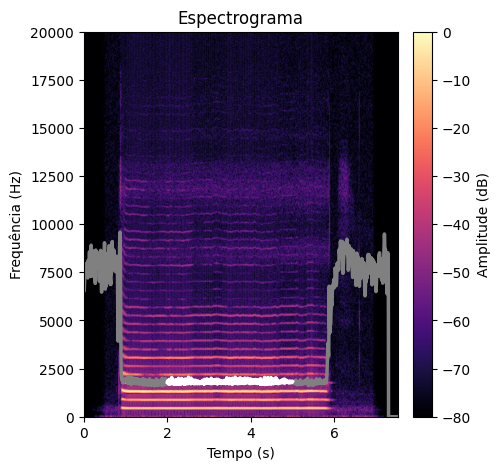

In [36]:
nota = 'A4'
material = 'plastico'
metodo = 'bending'
repeticao = 'rep4'

audio = acessaAudiosProc(nota, material, metodo, repeticao)
stft = calcSTFT(audio)

centroids_media, centroid_media = calcCentroid_media(stft)
centroids_mediana, centroid_mediana = calcCentroid_mediana(stft)
attack_time, _ = calcAttackTime(audio)

plotaEspectro(stft, centroids_media, centroids_mediana)

# Dataset

In [37]:
# Código para criar o dataframe
data = {
    'nota': [],
    'material': [],
    'metodo': [],
    'rep': [],
    'centroide': [],
    'atk_time': []
}

for nota, materiais in audios_processados.items():
    for material, metodos in materiais.items():
        for metodo, repeticoes in metodos.items():
            for repeticao, dados_audio in repeticoes.items():

                audio = acessaAudiosProc(nota, material, metodo, repeticao)
                stft = calcSTFT(audio)
                
                # Descritores
                _, centroid_media = calcCentroid_media(stft)
                attack_time, _ = calcAttackTime(audio)

                # Monta linha do dataset
                data['nota'].append(nota)
                data['material'].append(material)
                data['metodo'].append(metodo)
                data['rep'].append(repeticao)
                data['centroide'].append(centroid_media)
                data['atk_time'].append(attack_time)

In [38]:
import pandas as pd

df = pd.DataFrame(data)
df.to_csv('../dados/timbre_descritores.csv', index=False)

pd.set_option('display.max_rows', None)
df

,nota,material,metodo,rep,centroide,atk_time
0,A4,madeira,natural,rep3,5021.961701,0.112880
1,A4,madeira,natural,rep2,5091.258682,0.092449
2,A4,madeira,natural,rep1,5144.156490,0.141610
3,A4,madeira,natural,rep5,4985.094972,0.154059
4,A4,madeira,natural,rep4,5007.490913,0.128503
5,A4,madeira,bending,rep2,1852.400992,0.033991
6,A4,madeira,bending,rep3,1866.909252,0.045578
7,A4,madeira,bending,rep4,1823.661563,0.049932
8,A4,madeira,bending,rep1,1849.779501,0.055601
9,A4,madeira,bending,rep5,1882.858329,0.033038
